In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

pd.set_option('display.max_rows', None)

In [2]:
# Reading file  

#df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'))
#station_locations_by_hash = df[df['hash'] == hashid]
#lons = station_locations_by_hash['LONGITUDE'].tolist()
#lats = station_locations_by_hash['LATITUDE'].tolist()

weatherDf = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
weatherDf.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [3]:
# Filtering DF, so it contains only data from 2005 to 2014

weather0514 = weatherDf[(weatherDf['Date'] <='2014-12-31') & (weatherDf['Date'] >= '2005-01-01')].copy()
weather0514['Data_Value'] = weather0514['Data_Value']/10
weather0514['Date'] = pd.to_datetime(weather0514['Date'], format="%Y-%m-%d")

In [4]:
# Creating new dataframes, where it contains temperature max and min record daily over the period 2005-2014

# Max:
# First I filter DF, so I'd have observations where temperature max is recorded:
weather0514TMAX = weather0514[weather0514['Element'] == 'TMAX'].copy()
# Since there are multiple dates with TMAX, I select only the highest one using pivot table and aggfunc = max
weather0514TMAX = pd.pivot_table(weather0514TMAX, values='Data_Value',
                                index='Date', aggfunc = max)
# Creating dataframe from the series file:
weather0514TMAX = pd.DataFrame({'Date': weather0514TMAX.index,
                                'TMAX': weather0514TMAX.values})
# Since I need to have daily highest value over the period 2005-2014, I change date's year to 2020, so every the same day,
# the same year and I could filter on day.
weather0514TMAX['Day'] = weather0514TMAX['Date'].dt.strftime('2020-%m-%d')
# Selecting the max value on day:
weather0514TMAX = pd.pivot_table(weather0514TMAX, values = 'TMAX',
                                index='Day', aggfunc = max).to_frame().reset_index()

# Min:
weather0514TMIN = weather0514[weather0514['Element'] == 'TMIN'].copy()
weather0514TMIN = pd.pivot_table(weather0514, values='Data_Value',
                                index='Date', aggfunc = min)
weather0514TMIN = pd.DataFrame({'Date': weather0514TMIN.index,
                                'TMIN': weather0514TMIN.values})
weather0514TMIN['Day'] = weather0514TMIN['Date'].dt.strftime('2020-%m-%d')
weather0514TMIN = pd.pivot_table(weather0514TMIN, values = 'TMIN',
                                index='Day', aggfunc = min).to_frame().reset_index()

weather0514TMAX.head() # <- Here you see the day with year 2020. You would need to look only into the month and day,
                       # since we don't have values with 2020 year:

,Day,TMAX
0,2020-01-01,15.6
1,2020-01-02,13.9
2,2020-01-03,13.3
3,2020-01-04,10.6
4,2020-01-05,12.8


In [5]:
# Mergin dataframes:

weather0514TMAXTMIN = weather0514TMAX.merge(weather0514TMIN, on="Day", how="left")
weather0514TMAXTMIN.head()

,Day,TMAX,TMIN
0,2020-01-01,15.6,-16.0
1,2020-01-02,13.9,-26.7
2,2020-01-03,13.3,-26.7
3,2020-01-04,10.6,-26.1
4,2020-01-05,12.8,-15.0


In [6]:
# Now, processing the same information for year 2015:

# Filtering the year 
weather15 = weatherDf[(weatherDf['Date'] >= '2015-01-01') & (weatherDf['Date'] <= '2015-12-31')].copy()
#
weather15['Data_Value'] = weather15['Data_Value'] / 10
weather15['Date'] = pd.to_datetime(weather15['Date'], format="%Y-%m-%d")

# Finding Max and Min
weather15TMAX = weather15[weather15['Element'] == 'TMAX'].copy()
weather15TMAX = pd.pivot_table(weather15TMAX, values='Data_Value',
                                index='Date', aggfunc = max)
weather15TMAX = pd.DataFrame({'Date': weather15TMAX.index,
                              'TMAX15': weather15TMAX.values})
weather15TMAX['Day'] = weather15TMAX['Date'].dt.strftime('2020-%m-%d')


weather15TMIN = weather15[weather15['Element'] == 'TMIN'].copy()
weather15TMIN = pd.pivot_table(weather15TMIN, values='Data_Value',
                                index='Date', aggfunc = min)

weather15TMIN = pd.DataFrame({'Date': weather15TMIN.index,
                              'TMIN15': weather15TMIN.values})
weather15TMIN['Day'] = weather15TMIN['Date'].dt.strftime('2020-%m-%d')

# Merge Min and Max DF
weather15TMAXTMIN = weather15TMAX.merge(weather15TMIN, on="Day", how="left")

# Merge 2005-2014 and 2015 DF
weatherTMAXTMIN = weather0514TMAXTMIN.merge(weather15TMAXTMIN, on="Day", how="left")
# Selecting only needed columns
weatherTMAXTMIN = weatherTMAXTMIN[['Day', 'TMAX', 'TMIN', 'TMAX15', 'TMIN15']]

weatherTMAXTMIN.head()

,Day,TMAX,TMIN,TMAX15,TMIN15
0,2020-01-01,15.6,-16.0,1.1,-13.3
1,2020-01-02,13.9,-26.7,3.9,-12.2
2,2020-01-03,13.3,-26.7,3.9,-6.7
3,2020-01-04,10.6,-26.1,4.4,-8.8
4,2020-01-05,12.8,-15.0,2.8,-15.5


In [7]:
# Now, I'm finding the values, where 2015 has broken high and low temperature record of 2004-2014.
# If the record wasn't broken, I assign to the column TMAX15 Nan value, so it wouldn't be represented on graph.
# If the record is broken, the value is left as it is.
# The same goes for TMIN15 values
weatherTMAXTMIN.loc[weatherTMAXTMIN['TMAX15'] <= weatherTMAXTMIN['TMAX'], 'TMAX15'] = np.nan
weatherTMAXTMIN.loc[weatherTMAXTMIN['TMIN15'] >= weatherTMAXTMIN['TMIN'], 'TMIN15'] = np.nan

weatherTMAXTMIN.head()

,Day,TMAX,TMIN,TMAX15,TMIN15
0,2020-01-01,15.6,-16.0,NaN,NaN
1,2020-01-02,13.9,-26.7,NaN,NaN
2,2020-01-03,13.3,-26.7,NaN,NaN
3,2020-01-04,10.6,-26.1,NaN,NaN
4,2020-01-05,12.8,-15.0,NaN,-15.5


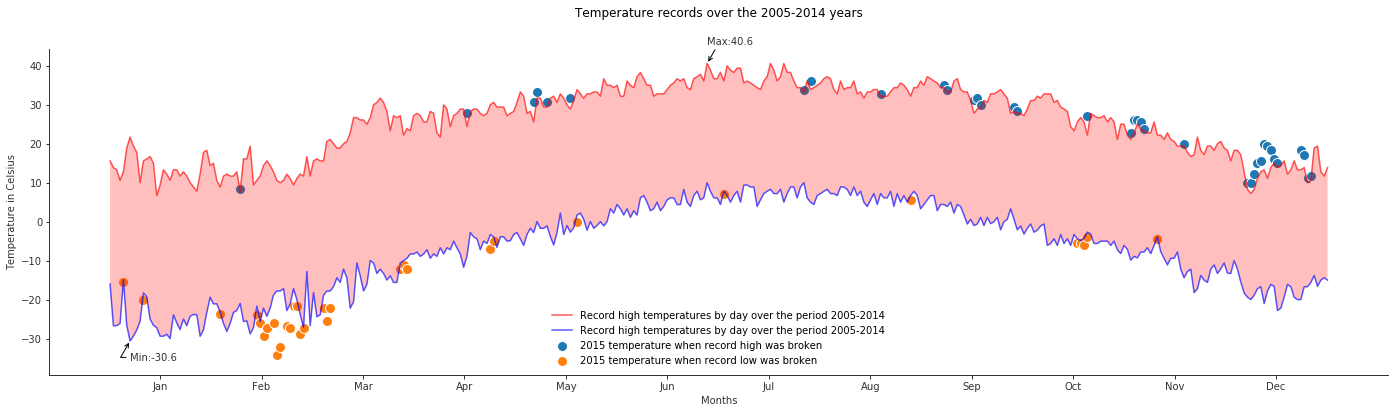

In [8]:
# Start working with graph:

weatherTMAXTMIN['Day'] = pd.to_datetime(weatherTMAXTMIN['Day'], format="%Y-%m-%d")
weatherTMAXTMIN['Day'] = weatherTMAXTMIN['Day'].dt.dayofyear - 1

# Set the size of graph:
fig = plt.figure(figsize=(24, 6))
# Get the axis:
ax = plt.gca()
# Plotting lines of temperature highs and lows daily over the period 2005-2014
plt.plot(weatherTMAXTMIN['Day'], weatherTMAXTMIN['TMAX'], '-r', color='r', alpha=0.65, label = "Record high temperatures by day over the period 2005-2014")
plt.plot(weatherTMAXTMIN['Day'], weatherTMAXTMIN['TMIN'], '-r', color='b', alpha=0.65, label = "Record high temperatures by day over the period 2005-2014")
# Plotting scatter plot on top to show when was the record broken of temperature highs and lows:
plt.scatter(weatherTMAXTMIN['Day'], weatherTMAXTMIN['TMAX15'], s=100, edgecolors='white', label = "2015 temperature when record high was broken")
plt.scatter(weatherTMAXTMIN['Day'], weatherTMAXTMIN['TMIN15'], s=100, edgecolors='white', label = "2015 temperature when record low was broken")
# Creating shade between line plots
ax.fill_between(range(len(weatherTMAXTMIN)),
                      weatherTMAXTMIN['TMAX'], weatherTMAXTMIN['TMIN'],
                      facecolor='red', alpha=0.25)
# Setting x axis ticks to months and reducing it's opacity to 0.8
plt.xticks(np.linspace(15,380,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'), alpha=0.8)
plt.yticks(alpha=0.8)

# Setting labels
ax.set_ylabel("Temperature in Celsius", alpha=0.8)
ax.set_xlabel("Months", alpha=0.8)

# Removing frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.axes.get_yaxis().set_ticks([])   # <-- Removes ticks

# Setting the title:
plt.title('Temperature records over the 2005-2014 years', y = 1.08)

# Adding the legend to the graph and reducing its elements' opacity
leg = plt.legend(loc="lower center")
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
# Removing frame from legend
plt.legend(frameon=False)

# Finding the maximum graph value and marking it on the graph by arrow:
ymax = max(weatherTMAXTMIN['TMAX'])
xmax = weatherTMAXTMIN.loc[weatherTMAXTMIN['TMAX'].idxmax(), 'Day']
ax.annotate('Max:{}'.format(ymax), xy=(xmax, ymax),
            xytext = (xmax, ymax + 5),
           arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60"),
           alpha=0.8)

# Finding the minimum graph value and marking it on the graph by arrow:
ymin = min(weatherTMAXTMIN['TMIN'])
xmin = weatherTMAXTMIN.loc[weatherTMAXTMIN['TMIN'].idxmin(), 'Day']
ax.annotate('Min:{}'.format(ymin), xy=(xmin, ymin),
            xytext = (xmin, ymin - 5),
            arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60"),
           alpha=0.8)

# saving graph
fig.savefig('Graph.png')

plt.show()


#mpl.pyplot.figure().clear()
#mpl.pyplot.close()